## Read file

In [48]:
import pandas as pd
import tqdm
from tqdm import tqdm, tqdm_pandas
from multiprocessing import Pool
import multiprocessing
n_cpu = multiprocessing.cpu_count()
import re
import numpy as np
import gensim
from gensim.corpora.dictionary import Dictionary
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
import pyLDAvis.gensim
import pyLDAvis
from gensim.models import CoherenceModel
%matplotlib inline

### Business

In [2]:
chunk = pd.read_json('business_train.json',orient = 'records',lines=True,chunksize = 10000)
i=0
for c in chunk:
    if i == 0:
        business = c
    else:
        business = business.append(c)
    i = i +1

In [3]:
business = business.drop(business[business.categories.isna()].index)

In [4]:
def restaurant_index(categories):
    if re.findall('restaurants',categories.lower()) != []:
        return True
    else:
        return False

In [5]:
restaurant = business.categories.apply(restaurant_index)

restaurants = business[restaurant]

restaurants = restaurants.drop(['postal_code','state'],axis = 1)

In [6]:
restaurants = restaurants.set_index(np.arange(0,restaurants.shape[0]))

In [7]:
del business

In [8]:
def kill_restaurant(text, cores = n_cpu-1):
    with Pool(processes=cores) as pool:
        result = pool.map(kill,text)
    return result
def kill(text):
    return re.sub('restaurants','',text.lower())
restaurants.categories = kill_restaurant(restaurants.categories)

In [9]:
def tokenize(text):
    token = [re.sub(' ','_',x.strip()) for x in text.split(',')]
    token = [x for x in token if x != 'food' and x != '']
    return token

In [10]:
def token(text, cores=n_cpu-1):
    with Pool(processes=cores) as pool:
        result = pool.map(tokenize,text)
    return result

In [11]:
restaurants.categories = token(restaurants.categories)

In [12]:
restaurants_dictionary = Dictionary(restaurants.categories.values)

restaurants_corpus = [restaurants_dictionary.doc2bow(text) for text in restaurants.categories.values]

In [13]:
from gensim.models import ldamodel as LDA

In [14]:
lda_model = LDA.LdaModel(restaurants_corpus,
                         id2word=restaurants_dictionary,
                         num_topics = 5,
                         alpha='auto',
                         per_word_topics=True,
                         random_state = 123)

In [15]:
lda_model.print_topics()

[(0,
  '0.176*"fast_food" + 0.156*"burgers" + 0.116*"sandwiches" + 0.114*"american_(traditional)" + 0.050*"chicken_wings" + 0.043*"breakfast_&_brunch" + 0.042*"indian" + 0.036*"diners" + 0.036*"delis" + 0.023*"american_(new)"'),
 (1,
  '0.125*"japanese" + 0.102*"sushi_bars" + 0.089*"event_planning_&_services" + 0.078*"mediterranean" + 0.054*"middle_eastern" + 0.048*"caterers" + 0.046*"greek" + 0.028*"canadian_(new)" + 0.028*"caribbean" + 0.027*"venues_&_event_spaces"'),
 (2,
  '0.155*"pizza" + 0.108*"italian" + 0.075*"cafes" + 0.074*"sandwiches" + 0.072*"coffee_&_tea" + 0.070*"breakfast_&_brunch" + 0.057*"salad" + 0.044*"bakeries" + 0.038*"desserts" + 0.027*"barbeque"'),
 (3,
  '0.166*"nightlife" + 0.160*"bars" + 0.068*"american_(new)" + 0.060*"american_(traditional)" + 0.052*"seafood" + 0.036*"sports_bars" + 0.029*"pubs" + 0.024*"canadian_(new)" + 0.022*"wine_&_spirits" + 0.022*"beer"'),
 (4,
  '0.187*"mexican" + 0.182*"chinese" + 0.069*"asian_fusion" + 0.068*"thai" + 0.057*"specialty

In [16]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, restaurants_corpus, restaurants_dictionary)
vis

/Users/songsong/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.020130  0.280824       1        1  29.177582
2     -0.249150 -0.089773       2        1  24.430946
0     -0.228898 -0.066281       3        1  19.826681
4      0.250738 -0.306959       4        1  13.459076
1      0.247439  0.182189       5        1  13.105713, topic_info=     Category         Freq                       Term        Total  loglift  \
term                                                                          
15    Default  6760.000000                  nightlife  6760.000000  30.0000   
14    Default  6485.000000                       bars  6485.000000  29.0000   
9     Default  5287.000000                      pizza  5287.000000  28.0000   
4     Default  3497.000000                    mexican  3497.000000  27.0000   
10    Default  4323.000000                    burgers  4323.000000  26.0000   
3     Default  5854.000000                  fast_food  5854.000000  25.0000   
21    Default  3607.000000                    chinese  3607.000000  24.0000   
8     Default  3742.000000                    italian  3742.000000  23.0000   
13    Default  5724.000000                 sandwiches  5724.000000  22.0000   
0     Default  2275.000000                   japanese  2275.000000  21.0000   
35    Default  5650.000000     american_(traditional)  5650.000000  20.0000   
1     Default  1866.000000                 sushi_bars  1866.000000  19.0000   
39    Default  2622.000000                      cafes  2622.000000  18.0000   
44    Default  2226.000000  event_planning_&_services  2226.000000  17.0000   
62    Default  1431.000000              mediterranean  1431.000000  16.0000   
17    Default  3008.000000               coffee_&_tea  3008.000000  15.0000   
12    Default  1983.000000                      salad  1983.000000  14.0000   
119   Default  1278.000000                       thai  1278.000000  13.0000   
49    Default  2126.000000                    seafood  2126.000000  12.0000   
45    Default  1708.000000               asian_fusion  1708.000000  11.0000   
2     Default  4150.000000         breakfast_&_brunch  4150.000000  10.0000   
64    Default  1494.000000                   bakeries  1494.000000   9.0000   
47    Default  1597.000000             specialty_food  1597.000000   8.0000   
53    Default  1024.000000                 vietnamese  1024.000000   7.0000   
38    Default   996.000000             middle_eastern   996.000000   6.0000   
7     Default  2186.000000              chicken_wings  2186.000000   5.0000   
43    Default  1471.000000                   caterers  1471.000000   4.0000   
76    Default  1164.000000                     indian  1164.000000   3.0000   
55    Default  1475.000000                sports_bars  1475.000000   2.0000   
89    Default   834.000000                      greek   834.000000   1.0000   
...       ...          ...                        ...          ...      ...   
271    Topic5   169.998993                 food_court   170.803787   2.0274   
134    Topic5   216.098984                active_life   217.216110   2.0270   
181    Topic5   152.648712                    casinos   153.491547   2.0266   
63     Topic5   132.795135                    turkish   133.650940   2.0257   
184    Topic5   118.910027                    falafel   119.731140   2.0252   
83     Topic5   101.844330              beauty_&_spas   102.649689   2.0242   
169    Topic5   485.560669      venues_&_event_spaces   489.700348   2.0236   
186    Topic5    99.922043     party_&_event_planning   100.832253   2.0231   
143    Topic5    85.205734                  pan_asian    86.029961   2.0225   
151    Topic5    75.166412                      kebab    75.967064   2.0215   
257    Topic5    62.041508                   day_spas    62.840755   2.0193   
204    Topic5    60.907471                    arabian    61.718727   2.0189   
136    Topic5    59.0453

In [17]:
fastfood = [restaurants_dictionary[x[0]] for x in lda_model.get_topic_terms(topicid=0)]

In [18]:
japan = [restaurants_dictionary[x[0]] for x in lda_model.get_topic_terms(topicid=1)]

In [22]:
pizza = [restaurants_dictionary[x[0]] for x in lda_model.get_topic_terms(topicid=2)]
fastfood.extend(pizza)

In [23]:
bars = [restaurants_dictionary[x[0]] for x in lda_model.get_topic_terms(topicid=3)]

In [24]:
asian = [restaurants_dictionary[x[0]] for x in lda_model.get_topic_terms(topicid=4)]

In [28]:
import itertools

In [29]:
for x in itertools.combinations([fastfood,japan,bars,asian],2):
    print([set(x[0]).intersection(x[1]),x[0][0],x[1][0]])

[set(), 'fast_food', 'japanese']
[{'american_(traditional)', 'american_(new)'}, 'fast_food', 'nightlife']
[{'fast_food'}, 'fast_food', 'mexican']
[{'canadian_(new)'}, 'japanese', 'nightlife']
[set(), 'japanese', 'mexican']
[set(), 'nightlife', 'mexican']


In [30]:
def classify(text):
    x = [0,0,0,0]
    if len(set(text).intersection(fastfood)) != 0:
        x[0] = 1
    if len(set(text).intersection(bars)) != 0:
        x[1] = 1
    if len(set(text).intersection(japan)) != 0:
        x[2] = 1
    if len(set(text).intersection(asian)) != 0:
        x[3] = 1
    return x
def classifier(text,cores=n_cpu-1):
    with Pool(processes=cores) as pool:
        result = pool.map(classify,text)
    return result


In [31]:
types = np.array(classifier(restaurants.categories.values))

In [32]:
restaurants.categories[0]

['sushi_bars', 'japanese']

In [33]:
rest_types = pd.DataFrame(types,columns=['fastfood','bars','japan','asian'])

In [38]:
restaurants = restaurants.join(rest_types)

In [40]:
ids = restaurants.business_id.values

In [41]:
fastfood = restaurants[restaurants.fastfood == 1].business_id
bars = restaurants[restaurants.bars == 1].business_id
japan = restaurants[restaurants.japan == 1].business_id
asian = restaurants[restaurants.asian == 1].business_id

### Reviews

In [43]:
chunk = pd.read_json('review_train.json',orient = 'records',lines=True,chunksize = 10000)
i=0
for c in chunk:
    c = c.drop('date',axis=1)
    if i == 0:
        train = c
    else:
        train = train.append(c)
    i = i +1

In [44]:
train_restaurants = train[train.business_id.isin(restaurants.business_id)]
del train

In [45]:
train_restaurants.to_csv('restaurants')

In [ ]:
train_restaurants = pd.read_csv('restaurants')

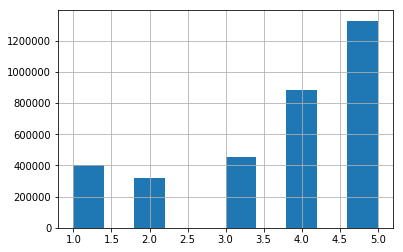

In [49]:
train_restaurants.stars.hist()

In [54]:
train_fastfood = train_restaurants[train_restaurants.business_id.isin(fastfood)]
train_japan = train_restaurants[train_restaurants.business_id.isin(japan)]
train_bars = train_restaurants[train_restaurants.business_id.isin(bars)]
train_asian = train_restaurants[train_restaurants.business_id.isin(asian)]

In [ ]:
del train_restaurants

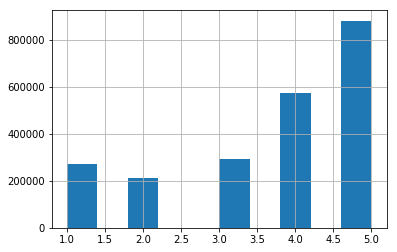

In [57]:
train_fastfood.stars.hist()

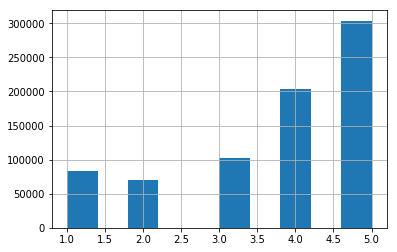

In [58]:
train_japan.stars.hist()

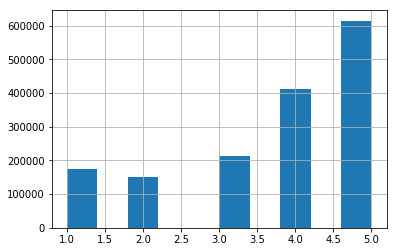

In [59]:
train_bars.stars.hist()

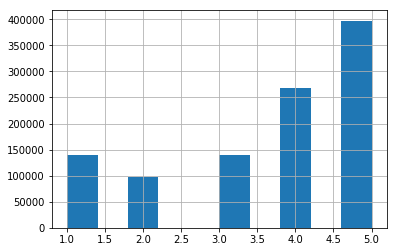

In [61]:
train_asian.stars.hist()

# 以下我还没弄好，不用看

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop.pop(stop.index('but'))
stop.pop(stop.index('not'))

In [ ]:
preposition = ['of','with','at','from','into','during',
               'including','until','till','against','among',
               'throughout','despite','towards','upon','concerning','to','in',
               'for','on','by','about','like','through','over',
               'before','between','after','since','without','under',
               'within','along','following','across','behind',
               'beyond','plus','except','but','up','out','around','down','off','above','near']
for prep in preposition:
    if prep in stop:
        stop.pop(stop.index(prep))

In [ ]:
but = ['yet','however','nonetheless','whereas','nevertheless']
although = ['though','notwithstanding','albeit']
def change_but(text):
    for x in but:
        text = re.sub(x,'but',text)
    return text
def change_although(text):
    for x in although:
        text = re.sub(x,'although',text)
    return text
def change_adversatives(text):
    text = change_but(text)
    text = change_although(text)
    return text

In [ ]:
def no_abbreviation(text):
    text = re.sub('can\'t','cannot',text)
    text = re.sub('won\'t','will not',text)
    text = re.sub('([a-z]*)n\'t','\\1 not',text)
    return text

In [ ]:
def utf8(text):
    x = str(text.encode('utf8'))
    x = re.sub('\\\\[a-zA-Z0-9]*','',x[2:(len(x)-1)])
    # ti qu biaoqing
    emoji = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',x)
    x = re.sub('(?::|;|=)(?:-)?(?:\)|\(|D|P)','',x)
    # qu huan hang fu 
    x = re.sub('\\n','',x.lower())
    x = change_adversatives(x)
    
    return (x,emoji)

In [ ]:
def english(text, cores=n_cpu-1):
    with Pool(processes=cores) as pool:
        result = pool.map(utf8,text)
    return result

In [ ]:
texts = english(test.text)

#### Lemmatization

In [ ]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
wnl = WordNetLemmatizer()
def lemmatizer(text):
    tokens = word_tokenize(text)
    
    lemmas = []
    pos = []
    tagged = pos_tag(tokens)
    for tag in tagged:
        wordnet_pos = get_wordnet_pos(tag[1]) or wordnet.NOUN
        if tag[0] not in preposition:
            lemmas.append(wnl.lemmatize(tag[0], pos=wordnet_pos))
            pos.append()
        else:
            lemmas.append(tag[0])
            
    return 

In [ ]:
lemmatizer('this will not be an apple')

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop.pop(stop.index('but'))
stop.pop(stop.index('not'))

preposition = ['of','with','at','from','into','during',
               'including','until','till','against','among',
               'throughout','despite','towards','upon','concerning','to','in',
               'for','on','by','about','like','through','over',
               'before','between','after','since','without','under',
               'within','along','following','across','behind',
               'beyond','plus','except','but','up','out','around','down','off','above','near']
for prep in preposition:
    if prep in stop:
        stop.pop(stop.index(prep))

In [ ]:
chunk = pd.read_json('review_train.json',orient = 'records',lines = True,chunksize= 10000)

In [ ]:
i = 0
for c in chunk:
    if i < 100:
        if i == 0:
            train = c
        else:
            train = train.append(c)
        i = i+1
        

In [ ]:
train = train.drop('date',axis=1)

In [ ]:
import re
import numpy as np 
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet

In [ ]:
wnl = WordNetLemmatizer()

In [ ]:
wnl.lemmatize('啊')

In [ ]:
wordnet.ADJ

In [ ]:
WordNetLemmatizer?

#### Language

In [ ]:
def not_language(text):
    # First delete all common emoticons.
    text = re.sub('(?::|;|=)(?:-)?(?:\)|\(|D|P)','',text)
    if re.sub('[\W]+','',text) == '':
        return True
    else:
        return False

In [ ]:
from langdetect import detect

In [ ]:
for i in 

In [ ]:
not_lang_train = train[train.text.apply(not_language)].index.values

In [ ]:
from langdetect import detect
for i in tqdm(range(train.shape[0])):
    if i in not_lang_train:
        continue
    else:
        if detect(train.text[i]) != 'en':
            train.drop(i)

#### Lemmatization

In [ ]:
porter = PorterStemmer()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [ ]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
wnl = WordNetLemmatizer()
def lemmatizer(text):
    tokens = word_tokenize(text)
    lemmas = []
    tagged = pos_tag(tokens)
    for tag in tagged:
        wordnet_pos = get_wordnet_pos(tag[1]) or wordnet.NOUN
        lemmas.append(wnl.lemmatize(tag[0], pos=wordnet_pos))
    return lemmas

#### Stop-words

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop.pop(stop.index('but'))
stop.pop(stop.index('not'))
preposition = ['of','with','at','from','into','during',
               'including','until','till','against','among',
               'throughout','despite','towards','upon','concerning','to','in',
               'for','on','by','about','like','through','over',
               'before','between','after','since','without','under',
               'within','along','following','across','behind',
               'beyond','plus','except','but','up','out','around','down','off','above','near']
for prep in preposition:
    if prep in stop:
        stop.pop(stop.index(prep))

#### Adversatives

In [ ]:
def preprocessing(text):
    # 取表情
    #emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',text)
    # 去回车
    text = re.sub('\\n',' ',text)
    # 只保留字母
    text = re.sub('[\W]+',' ', text.lower())
    # 统一转折词
    #text = change_adversatives(text)
    # 词性还原
    tokens = lemmatizer(text)
    i = 0
    for index, token in enumerate(tokens):
        if token in stop:
            tokens[index] = ''
            i += 1
    while i>0:
        tokens.pop(tokens.index(''))
        i -=1
    return text

In [ ]:
tqdm.pandas()
train.text = train.text.progress_apply(preprocessing)

#### Bigrams for phrase

In [ ]:
from gensim.models.phrases import Phrases, Phraser

In [ ]:
sentence_stream = train.text.values

In [ ]:
bigram = Phraser(Phrases(sentence_stream, min_count=5, threshold=5))

In [ ]:
sentence_with_phrase = bigram[sentence_stream]

In [ ]:
train.text = sentence_with_phrase

In [ ]:
from autocorrect import spell
def spell_sentences(text):
    return [spell(x) for x in text.split(' ')]

train.text = train.text.progress_apply(spell_sentences)

In [ ]:
train.to_csv('1.csv',index = False,index_label=False)

In [ ]:
chunk = pd.read_json('review_test.json',orient = 'records',lines = True,chunksize= 10000)
i=0
for c in chunk:
    if i ==0:
        test = c
    else:
        test = test.append(c)
    i = i+1

In [ ]:
test = test.drop('KaggleID',axis=1).drop('date',axis=1)

In [ ]:
text_train = [x for x in train.text.values]

In [ ]:
text_test = [x for x in test.text.values]

In [ ]:
text_train.extend(text_test)

In [ ]:
len(text_train)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tf = TfidfVectorizer(analyzer='word', min_df = 1, lowercase = True)
response =  tf.fit_transform(text_train)

In [ ]:
tfidf_train = response[:1000000]
tfidf_test = response[1000000:]

In [ ]:
y = train.stars

In [ ]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(multi_class='multinomial',solver='newton-cg',fit_intercept=True)
lr.fit(tfidf_train,y)

In [ ]:
y_pred=lr.predict(tfidf_test)

In [ ]:
kaggleid = np.array(range(1,len(y_pred)+1))

In [ ]:
header = np.array([['Id','Expected']])

In [ ]:
y_pred = y_pred.reshape([-1,1])
kaggleid = kaggleid.reshape([-1,1])
ans = np.hstack((kaggleid, y_pred))
ans = np.vstack((header, ans))
np.savetxt("TueG1_submit2.csv", ans, delimiter=",", fmt='%s')

In [ ]:
train.shape

#### Read sparse matrix

In [ ]:
def save_sparse_csr(filename, array):
    
    np.savez(filename, data=array.data, indices=array.indices,
             indptr=array.indptr, shape=array.shape)
    
def load_sparse_csr(filename):
    
    loader = np.load(filename + '.npz')
    return csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                      shape=loader['shape'])

In [ ]:
save_sparse_csr(filename='100w_bigram',array=response)

In [ ]:
pat = re.compile(r'([A-Z][^\.!?]*[\.!?])', re.M)
pat.findall('This apple costs me $8. What the fuck?')